In [1]:
import cv2
import os
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models

In [5]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1')
model

Loaded pretrained weights for efficientnet-b1


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [2]:
import torchvision
m = torchvision.models.__dict__

In [3]:
m

{'__name__': 'torchvision.models',
 '__doc__': None,
 '__package__': 'torchvision.models',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f9feb4e65f8>,
 '__spec__': ModuleSpec(name='torchvision.models', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f9feb4e65f8>, origin='/home/cds-k/Desktop/road_segment/venv/lib/python3.6/site-packages/torchvision/models/__init__.py', submodule_search_locations=['/home/cds-k/Desktop/road_segment/venv/lib/python3.6/site-packages/torchvision/models']),
 '__path__': ['/home/cds-k/Desktop/road_segment/venv/lib/python3.6/site-packages/torchvision/models'],
 '__file__': '/home/cds-k/Desktop/road_segment/venv/lib/python3.6/site-packages/torchvision/models/__init__.py',
 '__cached__': '/home/cds-k/Desktop/road_segment/venv/lib/python3.6/site-packages/torchvision/models/__pycache__/__init__.cpython-36.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworth

# Data

In [3]:
image_dir = './data/Images'
train_path = './data/Train.csv'
test_path = './data/Test.csv'
pred_path = './submissions/ensemble_4x_resnet18.csv'

In [4]:
df = pd.read_csv(train_path)
df.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


In [5]:
test_df = pd.read_csv(test_path)
test_df.head()

,Image_ID
0,ID_01c6i2wd
1,ID_03sPqBLY
2,ID_06ZKUQFl
3,ID_06gzqIwK
4,ID_08kWat36


In [6]:
df['Target'].value_counts()

1    3771
0    3229
Name: Target, dtype: int64

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image_ID  3000 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


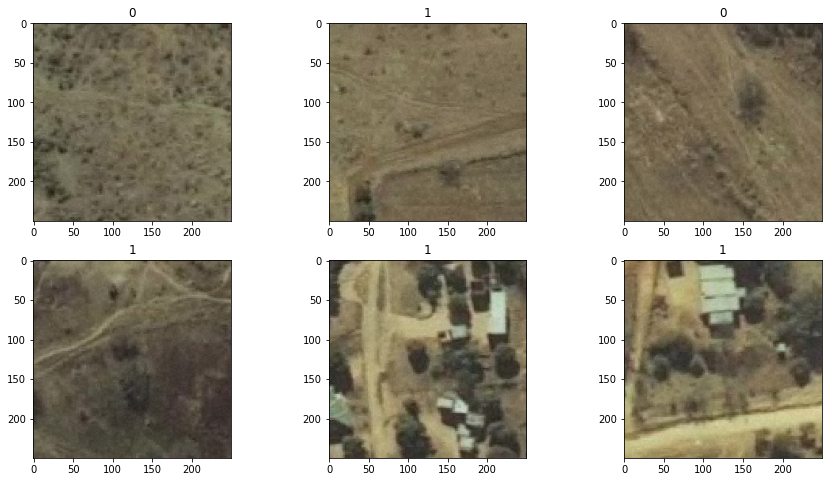

In [15]:
from utils import show_random

show_random(df, image_dir)

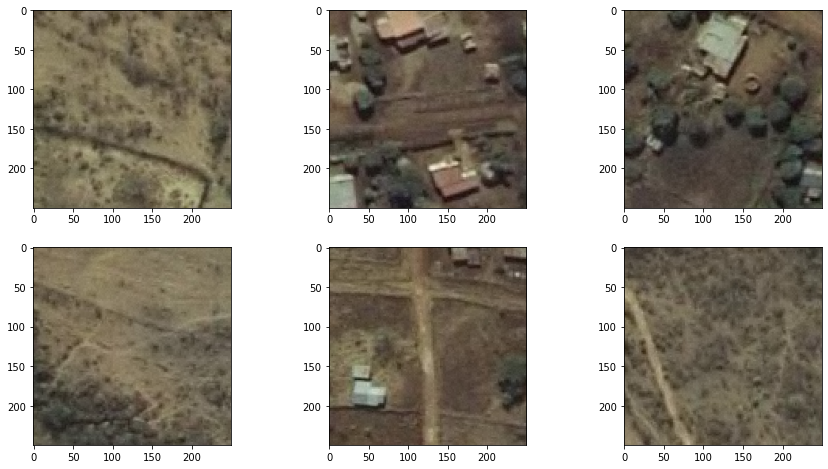

In [14]:
show_random(test_df, image_dir)

# Check augmentations

### https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/migrating_from_torchvision_to_albumentations.ipynb

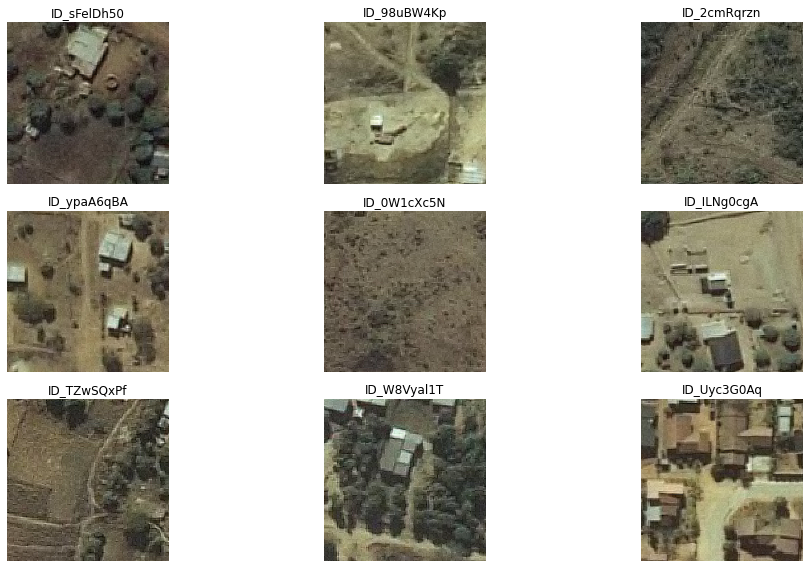

In [27]:
from dataset import RoadSegment, RoadSegmentTest
from utils import get_transform, visualize_augmentations
import albumentations as A

train_transform = A.Compose([
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.95, 1.0), p=1)
    ])
road_dataset = RoadSegmentTest(test_df, image_dir, train_transform)
visualize_augmentations(road_dataset)

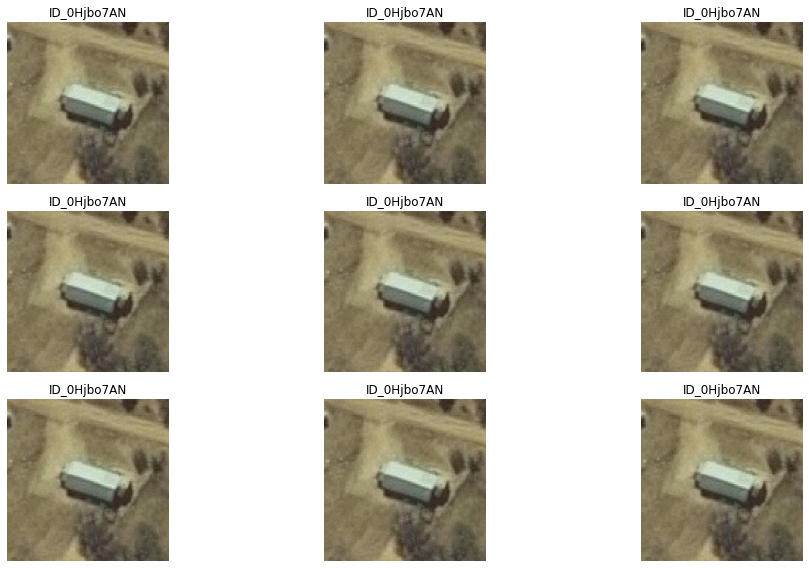

In [21]:
train_transform = A.Compose([
        A.CenterCrop(225, 225)
    ])
road_dataset = RoadSegmentTest(test_df, image_dir, train_transform)
visualize_augmentations(road_dataset, 10)

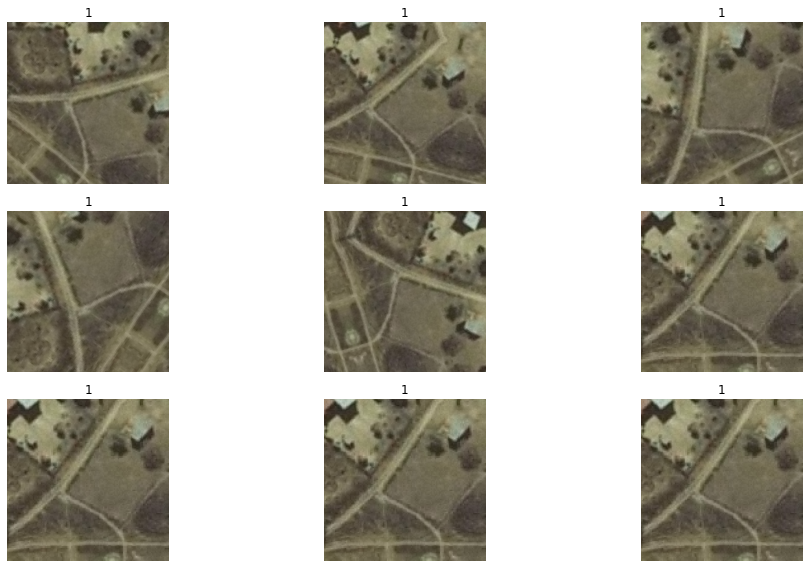

In [13]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset, 10)

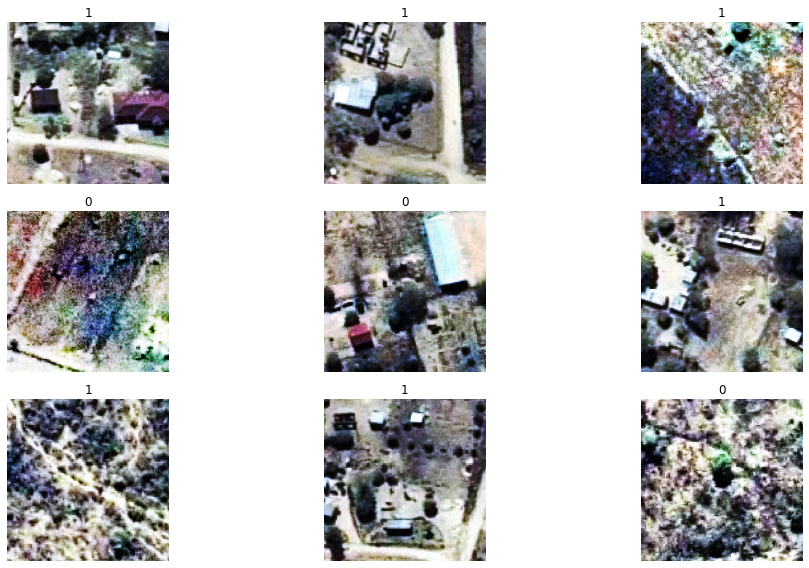

In [14]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.Equalize(p=1)
        #A.RandomBrightnessContrast(p=0.5),
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset)

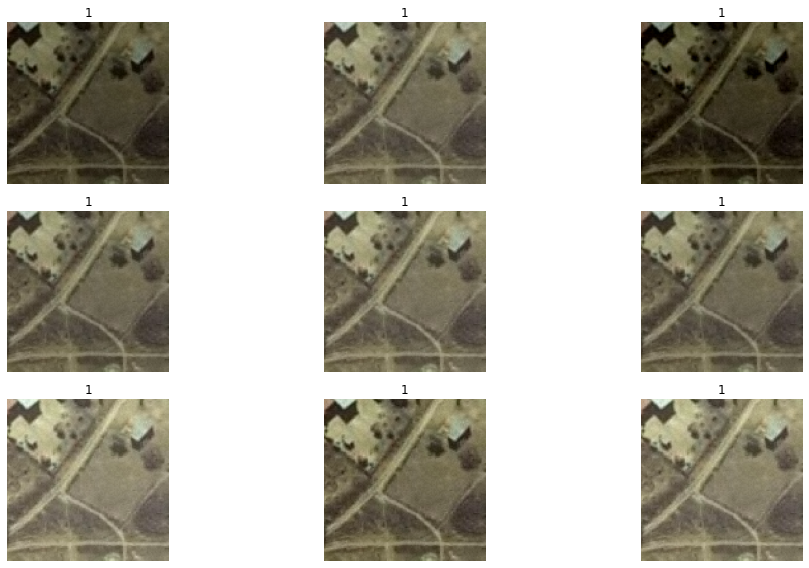

In [16]:
train_transform = A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
        #A.CoarseDropout(min_height=32, max_height=48, min_width=32, max_width=48, p=0.5),
        #A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.Equalize(p=1)
    ])
road_dataset = RoadSegment(df, image_dir, train_transform)
visualize_augmentations(road_dataset, 10)